# Test `erddapy`

In [22]:
from erddapy import ERDDAP


server_url = 'https://data.ioos.us/gliders/erddap'

e = ERDDAP(server_url=server_url)

In [28]:
import pandas as pd


df = pd.read_csv(e.search_url(response='csv', search_for='all'))

In [45]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 267 tabledap, 0 griddap, and 0 wms endpoints.'

### Let's filter that!

### Helper function to parse `datetime` objects to `seconds since 1970-01-01T00:00:00Z`

In [2]:
from datetime import datetime


def parse_dates(date_time, calendar='standard'):
    """
    FIXME: not sure how true this asssumption is!
    ERDDAP can take a variety of time constraints, we chose to use only
    `seconds since 1970-01-01T00:00:00Z` so the user can parse the dates in any way they like,
    and provide a datetime object to this function.

    """
    from netCDF4 import netcdftime

    utime = netcdftime.utime('seconds since 1970-01-01T00:00:00Z', calendar=calendar)
    return utime.date2num(date_time)

### Search parameters

In [3]:
min_time = datetime.strptime('2016-07-10T00:00:00Z', '%Y-%m-%dT%H:%M:%SZ')
max_time = datetime.strptime('2017-02-10T00:00:00Z', '%Y-%m-%dT%H:%M:%SZ')
min_time, max_time = parse_dates(min_time), parse_dates(max_time)

min_lat, max_lat =  38.0, 41.0
min_lon, max_lon = -72.0, -69.0

standard_name = 'sea_water_temperature'

### helper function to show HTML returns

In [4]:
def show_iframe(src):
    from IPython.display import HTML
    iframe = '<iframe src="{src}" width="100%" height="950"></iframe>'.format
    return HTML(iframe(src=src))

In [5]:
kw = dict(
    standard_name=standard_name,
    min_lat=min_lat,
    max_lat=max_lat,
    min_lon=min_lon,
    max_lon=max_lon,
    min_time=min_time,
    max_time=max_time
)

search_url = e.search_url(response='html', **kw)

show_iframe(search_url)

### Let's use a response we can use programmatically

In [6]:
search_url = e.search_url(response='csv', **kw)
search = pd.read_csv(search_url)
gliders = search['Dataset ID'].values

print('Found {} Glider Datasets:\n{}'.format(len(gliders), '\n'.join(gliders)))

Found 5 Glider Datasets:
blue-20160818T1448
cp_336-20170116T1254
silbo-20160413T1534
sp022-20170209T1616
whoi_406-20160902T1700


### We can use `info` to inspect the dataset

In [7]:
info_url = e.info_url(dataset_id=gliders[0], response='html')

show_iframe(src=info_url)

### Let's use the `csv` response again to manipulate the `info_url` data

In [8]:
info_url = e.info_url(dataset_id=gliders[0], response='csv')

info = pd.read_csv(info_url)

info.head()

,Row Type,Variable Name,Attribute Name,Data Type,Value
0,attribute,NC_GLOBAL,acknowledgement,String,This deployment supported by NOAA U.S. IOOS
1,attribute,NC_GLOBAL,cdm_data_type,String,TrajectoryProfile
2,attribute,NC_GLOBAL,cdm_profile_variables,String,"profile_id, time, latitude, longitude, time_uv..."
3,attribute,NC_GLOBAL,cdm_trajectory_variables,String,"trajectory, wmo_id"
4,attribute,NC_GLOBAL,comment,String,Glider deployed by the University of Massachus...


In [9]:
''.join(info.loc[info['Attribute Name'] == 'cdm_profile_variables', 'Value'])

'profile_id, time, latitude, longitude, time_uv, lat_uv, lon_uv, u, v'

## There is a convenience method to inspect the `dataset_id` variables

In [10]:
e.get_var_by_attr(dataset_id=gliders[0], standard_name=standard_name)

['temperature']

`get_var_by_attr` caches the last response in case the user needs to make multiple requests,
but it will loose its state when a new request is made. See the times below.

In [11]:
%%time

# First one, slow.
e.get_var_by_attr(
    dataset_id='blue-20160818T1448',
    standard_name='sea_water_temperature'
)

CPU times: user 51 µs, sys: 22 µs, total: 73 µs
Wall time: 78.2 µs


['temperature']

In [12]:
%%time

# Second one on the same glider, fast.
e.get_var_by_attr(
    dataset_id='blue-20160818T1448',
    standard_name='sea_water_practical_salinity'
)

CPU times: user 87 µs, sys: 37 µs, total: 124 µs
Wall time: 129 µs


['salinity']

In [13]:
%%time

# New one, slow.
e.get_var_by_attr(
    dataset_id='cp_336-20170116T1254',
    standard_name='sea_water_practical_salinity'
)

CPU times: user 94.1 ms, sys: 336 µs, total: 94.4 ms
Wall time: 1.52 s


['salinity']

### Let's check all the `dataset_id`s we got for the variables with `standard_names`

In [14]:
variables = [e.get_var_by_attr(dataset_id=glider, standard_name=lambda v: v is not None) for glider in gliders]

In [15]:
common_variables = set(variables[0]).intersection(*variables[1:])

common_variables

{'conductivity',
 'conductivity_qc',
 'density',
 'density_qc',
 'depth',
 'depth_qc',
 'lat_uv',
 'lat_uv_qc',
 'latitude',
 'latitude_qc',
 'lon_uv',
 'lon_uv_qc',
 'longitude',
 'longitude_qc',
 'precise_lat',
 'precise_lon',
 'precise_time',
 'precise_time_qc',
 'pressure',
 'pressure_qc',
 'salinity',
 'salinity_qc',
 'temperature',
 'temperature_qc',
 'time',
 'time_qc',
 'time_uv',
 'time_uv_qc',
 'u',
 'u_qc',
 'v',
 'v_qc'}

### Last but not least, the download endpoint

In [16]:
# I don't think inequalities are supported by REST.
# For simplicity I left them as part of the user input.
# Some googling tells me that the "correct" should be:
# time=min_time&gt=min_time&le=max_time
# not sure if ERDDAP supports that.
kwargs = {
    'time>=': min_time,
    'time<=': max_time,
    'latitude>=': min_lat,
    'latitude<=': max_lat,
    'longitude>=': min_lon,
    'longitude<=': max_lon,
}



download_url = e.download_url(dataset_id=gliders[0], variables=common_variables, response='html', **kwargs)

show_iframe(src=download_url)

### Again, using the `csv` to get a handy `pandas.DataFrame`

In [17]:
from urllib.error import HTTPError


def download_csv(url):
    return pd.read_csv(url, index_col='time', parse_dates=True, skiprows=[1])


dfs = {}
for glider in gliders:
    download_url = e.download_url(dataset_id=glider, variables=common_variables, response='csv', **kwargs)
    try:
        dfs.update({glider: download_csv(download_url)})
    except HTTPError:
        print('Failed to download {}'.format(glider))
        continue

Failed to download silbo-20160413T1534
Failed to download sp022-20170209T1616


In [18]:
import numpy as np

# mask values that should be masked upstream values.
for glider in dfs.keys():
    dfs[glider].loc[dfs[glider]['salinity_qc'] == 9, 'salinity'] = np.NaN
    dfs[glider].loc[dfs[glider]['pressure_qc'] == 9, 'pressure'] = np.NaN
    dfs[glider].loc[dfs[glider]['temperature_qc'] == 9, 'temperature'] = np.NaN
    dfs[glider].loc[dfs[glider]['salinity'] <= 0, 'salinity'] = np.NaN

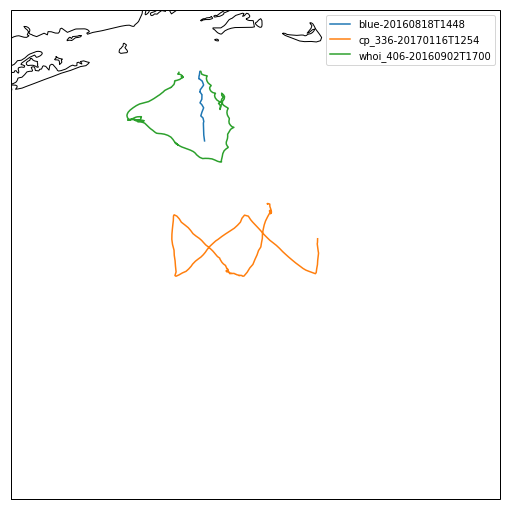

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(
    figsize=(9, 9),
    subplot_kw=dict(projection=ccrs.PlateCarree())
)
ax.coastlines(resolution='10m')
dx = dy = 0.5
ax.set_extent([min_lon-dx, max_lon+dx, min_lat-dy, max_lat+dy])

for glider, df in dfs.items():
    ax.plot(df['longitude'], df['latitude'], label=glider)

leg = ax.legend()

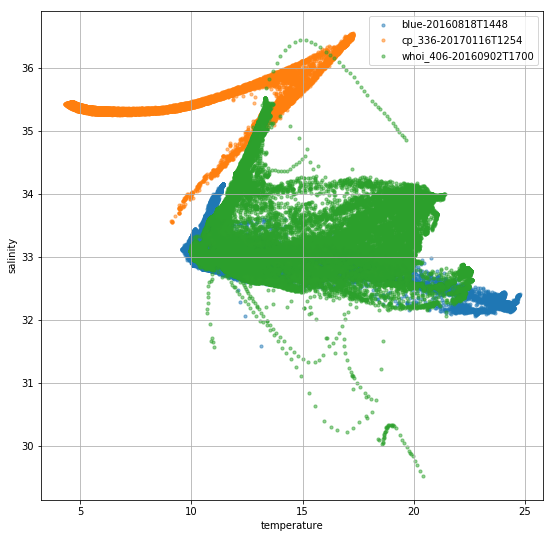

In [20]:
def glider_scatter(df, ax, glider):
    ax.scatter(df['temperature'], df['salinity'],
               s=10, alpha=0.5, label=glider)

fig, ax = plt.subplots(figsize=(9, 9))
ax.set_ylabel('salinity')
ax.set_xlabel('temperature')
ax.grid(True)

for glider, df in dfs.items():
    glider_scatter(df, ax, glider)

leg = ax.legend()

# Extras

- OPeNDAP

In [21]:
from netCDF4 import Dataset

opendap_url = e.opendap_url(gliders[0])
with Dataset(opendap_url) as nc:
    print(nc.summary)

U.S. IOOS Mid-Atlantic Regional Association Coastal Ocean Observing System (MARACOOS) glider deployment.  This is the second of a series of yearly seasonal deployments to survey the physical and biological properties of Mid-Atlantic Bight coastal waters.  The glider was deployed in Rhode Island Sound and will transect to Tuckerton, NJ.  This dataset contains physical (TS) data only.  Optical and oxygen data to be added at a later date.
